# Linear Probing on EuroSAT

## Imports

In [2]:
!pip install zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 kB 4.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 57.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install rasterio

In [3]:
# core train
import os
import numpy as np
import torch
import zarr
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import random
from skimage.transform import resize

import math
from functools import partial
import yaml

## Config

In [4]:
args = {
    "data": {
        "batch_size": 64,
        "crop_scale": [0.3, 1.0],
        "crop_size": 224,
        "image_folders": ["ssl-s2l1c/data/ssl4eo-s12/train/S2L1C",
                          "ssl-s2l2a/data/ssl4eo-s12/train/S2L2A"],
        "num_workers": 2,
        "pin_mem": True,
        "root_path": "/kaggle/input",
        "use_horizontal_flip": False
    },
    "logging": {
        "folder": "/kaggle/working/logs",
        "write_tag": "jepa"
    },
    "mask": {
        "allow_overlap": False,
        "aspect_ratio": [0.75, 1.5],
        "enc_mask_scale": [0.85, 1.0],
        "min_keep": 10,
        "num_enc_masks": 1,
        "num_pred_masks": 4,
        "patch_size": 14,
        "pred_mask_scale": [0.15, 0.2]
    },
    "meta": {
        "copy_data": False,
        "load_checkpoint": "True",
        "model_name": "vit_huge",
        "pred_depth": 12,
        "pred_emb_dim": 384,
        "read_checkpoint": None,
        "use_bfloat16": True
    },
    "optimization": {
        "ema": [0.996, 1.0],
        "epochs": 2,
        "final_lr": 1.0e-5,
        "final_weight_decay": 0.4,
        "ipe_scale": 1.0,
        "lr": 0.001,
        "start_lr": 0.0002,
        "warmup": 20,
        "weight_decay": 0.04
    }
}


In [5]:
resume_preempt = False
rank = 0

# -- META
use_bfloat16 = args['meta']['use_bfloat16']
model_name = args['meta']['model_name']
load_model = args['meta']['load_checkpoint'] or resume_preempt
r_file = args['meta']['read_checkpoint']
copy_data = args['meta']['copy_data']
pred_depth = args['meta']['pred_depth']
pred_emb_dim = args['meta']['pred_emb_dim']
if not torch.cuda.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)

# -- DATA
use_horizontal_flip = args['data']['use_horizontal_flip']
# --
batch_size = args['data']['batch_size']
pin_mem = args['data']['pin_mem']
num_workers = args['data']['num_workers']
root_path = args['data']['root_path']
image_folders = args['data']['image_folders']
crop_size = args['data']['crop_size']
crop_scale = args['data']['crop_scale']
# --

# -- MASK
allow_overlap = args['mask']['allow_overlap']  # whether to allow overlap b/w context and target blocks
patch_size = args['mask']['patch_size']  # patch-size for model training
num_enc_masks = args['mask']['num_enc_masks']  # number of context blocks
min_keep = args['mask']['min_keep']  # min number of patches in context block
enc_mask_scale = args['mask']['enc_mask_scale']  # scale of context blocks
num_pred_masks = args['mask']['num_pred_masks']  # number of target blocks
pred_mask_scale = args['mask']['pred_mask_scale']  # scale of target blocks
aspect_ratio = args['mask']['aspect_ratio']  # aspect ratio of target blocks
# --

# -- OPTIMIZATION
ema = args['optimization']['ema']
ipe_scale = args['optimization']['ipe_scale']  # scheduler scale factor (def: 1.0)
wd = float(args['optimization']['weight_decay'])
final_wd = float(args['optimization']['final_weight_decay'])
num_epochs = args['optimization']['epochs']
warmup = args['optimization']['warmup']
start_lr = args['optimization']['start_lr']
lr = args['optimization']['lr']
final_lr = args['optimization']['final_lr']

# -- LOGGING
folder = args['logging']['folder']
tag = args['logging']['write_tag']

os.makedirs(folder, exist_ok=True)
dump = os.path.join(folder, 'params-ijepa.yaml')
with open(dump, 'w') as f:
    yaml.dump(args, f)

## Data preprocessing

In [6]:
class Compose:
    """
    Composes several transforms together.
    Args:
        transforms (list of callables): list of transforms to compose.
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img_array):
        """
        Applies the composed transforms to the input array.
        The input can be a NumPy array. The output will be a torch.Tensor
        if torch.from_numpy is the last transform.
        Args:
            img_array (numpy.ndarray): Input image array (C, H, W).
        Returns:
            torch.Tensor: Transformed image tensor.
        """
        img_array = img_array.cpu().numpy()
        for t in self.transforms:
            img_array = t(img_array) # Note: img_array will become a torch.Tensor at the end
        return img_array


def scale_to_01_np(img_array, max_int_value=32767.0):
    """
    Scales positive integer values in a NumPy array to the 0-1 range.
    Assumes input values are positive and fit within max_int_value.
    Args:
        img_array (numpy.ndarray): Input image array.
        max_int_value (float): The maximum possible integer value in the original array.
                               For int16, this is typically 32767.
    Returns:
        numpy.ndarray: Scaled image array.
    """
    return img_array / max_int_value


def ensure_13_channels(img_array):
    """
    Ensures the input array has exactly 13 channels by adding the pixel-wise mean
    of the first 12 channels as the 13th channel.

    Args:
        img_array (numpy.ndarray): Input image array (C, H, W)

    Returns:
        numpy.ndarray: Array with exactly 13 channels
    """
    C, H, W = img_array.shape
    img_array = img_array.astype(np.float32)

    # If already 13 channels, return as is
    if C == 13:
        return img_array

    # If 12 channels, add pixel-wise mean as 13th channel
    elif C == 12:
        mean_channel = np.mean(img_array, axis=0, keepdims=True)  # Shape: (1, H, W)
        return np.concatenate([img_array, mean_channel], axis=0)

    # For other numbers of channels (unexpected case)
    else:
        raise ValueError(f"Expected 12 or 13 channels, but got {C}")

In [7]:
def get_inference_transforms(image_size=224):
    """Create transforms for inference without random augmentations."""
    transform_list = [
        # Convert input image to 13 channels if needed
        ensure_13_channels,  
        
        # Simple resize instead of random crop - with proper channel handling
        lambda x: resize_chw(x, image_size),
        
        # Scale to 0-1 range
        lambda x: scale_to_01_np(x, max_int_value=32767.0),
        
        # Convert to torch tensor
        torch.from_numpy
    ]
    
    # Create transform composition
    return Compose(transform_list)

def resize_chw(img, image_size):
    """
    Resize an image in CHW format (channels, height, width) to a square size.
    
    Args:
        img: NumPy array in shape (C, H, W)
        image_size: Target size (will be a square image)
        
    Returns:
        Resized image in shape (C, image_size, image_size)
    """
    # if isinstance(img, torch.Tensor):
    #     img = img.numpy()
        
    c, h, w = img.shape
    resized_img = np.zeros((c, image_size, image_size), dtype=img.dtype)
    
    # Resize each channel independently
    for i in range(c):
        # Temporarily reshape to (h, w) for resize
        channel = img[i]
        # Resize to target shape
        resized_channel = resize(channel, (image_size, image_size), 
                                order=1, mode='reflect', anti_aliasing=True)
        # Store back in the result array
        resized_img[i] = resized_channel
        
    return resized_img

In [8]:
def apply_masks(x, masks):
    """
    :param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep
    """
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1))
        all_x += [torch.gather(x, dim=1, index=mask_keep)]
    return torch.cat(all_x, dim=0)

## Defining JEPA model architecture (copied from training script)

In [9]:
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def repeat_interleave_batch(x, B, repeat):
    N = len(x) // B
    x = torch.cat([
        torch.cat([x[i*B:(i+1)*B] for _ in range(repeat)], dim=0)
        for i in range(N)
    ], dim=0)
    return x

In [10]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)

    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """
    3x3 Convolution stems for ViT following ViTC models
    """

    def __init__(self, channels, strides, img_size=224, in_chans=13, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3,
                               stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(
        self,
        num_patches,
        embed_dim=768,
        predictor_embed_dim=384,
        depth=6,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        init_std=0.02,
        **kwargs
    ):
        super().__init__()
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim),
                                                requires_grad=False)
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1],
                                                      int(num_patches**.5),
                                                      cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0))
        # --
        self.predictor_blocks = nn.ModuleList([
            Block(
                dim=predictor_embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.predictor_norm = norm_layer(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        self.init_std = init_std
        trunc_normal_(self.mask_token, std=self.init_std)
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.predictor_blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'

        if not isinstance(masks_x, list):
            masks_x = [masks_x]

        if not isinstance(masks, list):
            masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x)

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x)

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1)
        x += apply_masks(x_pos_embed, masks_x)

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)

        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(
        self,
        img_size=[224],
        patch_size=16,
        in_chans=13,
        embed_dim=768,
        predictor_embed_dim=384,
        depth=12,
        predictor_depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        init_std=0.02,
        **kwargs
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        # --
        self.patch_embed = PatchEmbed(
            img_size=img_size[0],
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1],
                                            int(self.patch_embed.num_patches**.5),
                                            cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # ------
        self.init_std = init_std
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list):
                masks = [masks]

        # -- patchify x
        x = self.patch_embed(x)
        B, N, D = x.shape

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        # -- mask x
        if masks is not None:
            x = apply_masks(x, masks)

        # -- fwd prop
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None:
            x = self.norm(x)

        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N:
            return pos_embed
        class_emb = pos_embed[:, 0]
        pos_embed = pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(
            pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=math.sqrt(npatch / N),
            mode='bicubic',
        )
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)


def vit_predictor(**kwargs):
    model = VisionTransformerPredictor(
        mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    return model


def vit_tiny(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_small(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_huge(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_giant(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1408, depth=40, num_heads=16, mlp_ratio=48/11,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


VIT_EMBED_DIMS = {
    'vit_tiny': 192,
    'vit_small': 384,
    'vit_base': 768,
    'vit_large': 1024,
    'vit_huge': 1280,
    'vit_giant': 1408,
}

## Helper functions

In [11]:
torch.manual_seed(42)

In [12]:
def load_checkpoint(
    device,
    r_path,
    encoder,
    predictor,
    target_encoder,
    opt,
    scaler,
):
    try:
        checkpoint = torch.load(r_path, map_location=torch.device('cpu'))
        epoch = checkpoint['epoch']

        # -- loading encoder
        pretrained_dict = checkpoint['encoder']
        msg = encoder.load_state_dict(pretrained_dict)

        # -- loading predictor
        pretrained_dict = checkpoint['predictor']
        msg = predictor.load_state_dict(pretrained_dict)

        # -- loading target_encoder
        if target_encoder is not None:
            print(list(checkpoint.keys()))
            pretrained_dict = checkpoint['target_encoder']
            msg = target_encoder.load_state_dict(pretrained_dict)

        # -- loading optimizer
        opt.load_state_dict(checkpoint['opt'])
        if scaler is not None:
            scaler.load_state_dict(checkpoint['scaler'])
        del checkpoint

    except Exception as e:
        epoch = 0

    return encoder, predictor, target_encoder, opt, scaler, epoch


def init_model(
    device,
    patch_size=16,
    model_name='vit_base',
    crop_size=224,
    pred_depth=6,
    pred_emb_dim=384
):
    encoder = vit_small(
        img_size=[crop_size],
        patch_size=patch_size)
    predictor = vit_predictor(
        num_patches=encoder.patch_embed.num_patches,
        embed_dim=encoder.embed_dim,
        predictor_embed_dim=pred_emb_dim,
        depth=pred_depth,
        num_heads=encoder.num_heads)

    def init_weights(m):
        if isinstance(m, torch.nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.LayerNorm):
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1.0)

    for m in encoder.modules():
        init_weights(m)

    for m in predictor.modules():
        init_weights(m)

    encoder.to(device)
    predictor.to(device)
    return encoder, predictor

## Core Linear Probing Implementation

### Feature extractor 
(wrapper class that calls the forward pass of the pretrained model and then returns the encoder representation)

In [13]:
class IJEPA_Extractor:
    def __init__(self, checkpoint_path, stats_path, device='cuda', include_predictor=True):
        """Load a pre-trained I-JEPA model for feature extraction and prediction visualization.
        
        Args:
            checkpoint_path: Path to the saved model checkpoint
            device: Device to run inference on ('cuda' or 'cpu')
            include_predictor: Whether to load the predictor for visualization
        """
        self.device = torch.device(device if torch.cuda.is_available() and device=='cuda' else 'cpu')

        
        # Load stats for normalization
        self.stats = torch.load(stats_path, map_location=self.device)
        
        # Initialize model architecture
        self.encoder, self.predictor = init_model(
            device=self.device,
            patch_size=14,  # Use the same patch_size as during training
            crop_size=224,  # Use standard size for inference
            model_name='vit_small',  # Use the same architecture as during training
            pred_depth=12,  # Use the same predictor depth as during training
            pred_emb_dim=384  # Use the same embedding dimension as during training
        )
        
        # Load weights from checkpoint
        if checkpoint_path != None:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device(self.device))
            self.encoder.load_state_dict(checkpoint['encoder'])
        self.encoder.eval()
        
        if include_predictor:
            if checkpoint_path != None:
                self.predictor.load_state_dict(checkpoint['predictor'])
            self.predictor.eval()
        else:
            self.predictor = None
        
        # Prepare transforms
        self.transforms = get_inference_transforms(224)


    def extract_features(self, image):
        """Extract features from a single image.
        
        Args:
            image: Input image in numpy format (C, H, W)
            
        Returns:
            features: Tensor of extracted features
        """
        # Apply transforms
        img = self.transforms(image)
        
        # Apply normalization
        mean = self.stats['mean'].to(self.device).view(-1, 1, 1)
        std = self.stats['std'].to(self.device).view(-1, 1, 1)
        img = (img - mean) / (std + 1e-8)
        
        # Add batch dimension and move to device
        img = img.unsqueeze(0).to(self.device)
        
        # Extract features
        with torch.no_grad():
            features = self.encoder(img)
            
        return features
        

    def batch_extract_features(self, images):
        """Extract features from a batch of images.
        
        Args:
            images: List of input images
            
        Returns:
            features: Batch tensor of extracted features
        """
        batch = []
        for img in images:
            # Apply transforms
            img = self.transforms(img)
            
            # Apply normalization
            mean = self.stats['mean'].to(self.device).view(-1, 1, 1)
            std = self.stats['std'].to(self.device).view(-1, 1, 1)
            img = (img - mean) / (std + 1e-8)
            
            batch.append(img)
        
        # Stack into batch and move to device
        batch = torch.stack(batch).to(self.device)
        
        # Extract features
        with torch.no_grad():
            features = self.encoder(batch)
            
        return features

### Defining the EuroSAT dataset used for linear probing

In [15]:
import rasterio
import pandas as pd
import json

class EuroSATDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.data_frame = pd.read_csv(os.path.join(root_dir, csv_file))
        self.root_dir = root_dir
        with open(os.path.join(root_dir, 'label_map.json'), 'r') as f:
            self.label_map = json.load(f)
        self.classes = list(self.label_map.keys())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.num_to_idx = {str(idx): idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx]['Filename'])

        with rasterio.open(img_path) as src:
            image = src.read()  # shape: (bands, height, width)

        label = self.data_frame.iloc[idx]['Label']
        label_str = str(label)
        if label_str in self.num_to_idx:
            label_idx = self.num_to_idx[label_str]
        else:
            raise KeyError(f"Label '{label_str}' not found in label_map.json")

        return image, label_idx


In [16]:
# Load datasets
train_dataset = EuroSATDataset(csv_file="train.csv", root_dir="/kaggle/input/eurosat-dataset/EuroSATallBands")
validation_dataset = EuroSATDataset(csv_file="validation.csv", root_dir="/kaggle/input/eurosat-dataset/EuroSATallBands")
test_dataset = EuroSATDataset(csv_file="test.csv", root_dir="/kaggle/input/eurosat-dataset/EuroSATallBands")

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=2)

### Model loading (if not randomly initialized run) & Linear Layer setup

In [ ]:
# Path to model checkpoint
checkpoint_path = None
stats_path = '/kaggle/input/jepa_small/pytorch/default/1/logs/dataset_stats.pth'

In [18]:
# Initialize the feature extractor
extractor = IJEPA_Extractor(checkpoint_path, stats_path, 'cuda')

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.classifier = nn.Linear(feature_dim, num_classes)
        
    def forward(self, x):
        # Average pooling over patch dimension to get global features
        x = x.mean(dim=1)
        return self.classifier(x)

### Training the linear layer

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = LinearClassifier(feature_dim=384, num_classes=10).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 25

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # ======== TRAINING ========
    classifier.train()
    total_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Feature extraction (frozen encoder)
        with torch.no_grad():
            features = extractor.batch_extract_features(images)

        # Forward pass
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        print(f"Current Train Loss: {loss:.4f} ")

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # ======== VALIDATION ========
    classifier.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_dataloader:
            images, labels = images.to(device), labels.to(device)
            features = extractor.batch_extract_features(images)
            outputs = classifier(features)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"Val Acc: {val_accuracy:.2f}%")

    if (epoch + 1) % 5 == 0:
        checkpoint_path = f"/kaggle/working/linear_classifier_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1} to {checkpoint_path}")



### Test Acc & Conf Matrix Calculation

In [21]:
device = torch.device('cpu')
classifier = LinearClassifier(feature_dim=384, num_classes=10).to(device)
checkpoint = torch.load('/kaggle/input/linear_random/pytorch/default/1/linear_classifier_epoch_20.pth', map_location=device)
classifier.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classifier.eval() # Set classifier in evaluation mode

with open(os.path.join("/kaggle/input/eurosat-dataset/EuroSATallBands", 'label_map.json'), 'r') as f:
    label_map = json.load(f)

# Invert the label_map to get class names from indices for display
idx_to_class = {v: k for k, v in label_map.items()}
class_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]


total_test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        print(f"Batch {i+1}/{len(test_dataloader)} processing...")

        images, labels = images.to(device), labels.to(device)
        features = extractor.batch_extract_features(images)
        outputs = classifier(features)

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Store labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


test_accuracy = 100 * correct / total
print(f"Test Acc: {test_accuracy:.2f}%")

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(cm)

Batch 1/11 processing...
Batch 2/11 processing...
Batch 3/11 processing...
Batch 4/11 processing...
Batch 5/11 processing...
Batch 6/11 processing...
Batch 7/11 processing...
Batch 8/11 processing...
Batch 9/11 processing...
Batch 10/11 processing...
Batch 11/11 processing...
Test Acc: 72.56%

Confusion Matrix:
[[193   8  24   6   2   7  36  21   3   0]
 [  0 285   7   0   0   7   0   0   1   0]
 [  2   8 236   0  11   8  11  18   6   0]
 [ 35  23  23  34   7  12  25  55  36   0]
 [  1   0   4   0 190   0   0  51   4   0]
 [  8  11  12   2   5 143  12   2   5   0]
 [ 12   1  12   8   2   1 195  17   2   0]
 [  3   3  12   6  23   2  25 207  17   2]
 [  3  25  19   8  11   6   3   9 163   3]
 [  0   0   0   0   1   0   0   0   2 356]]


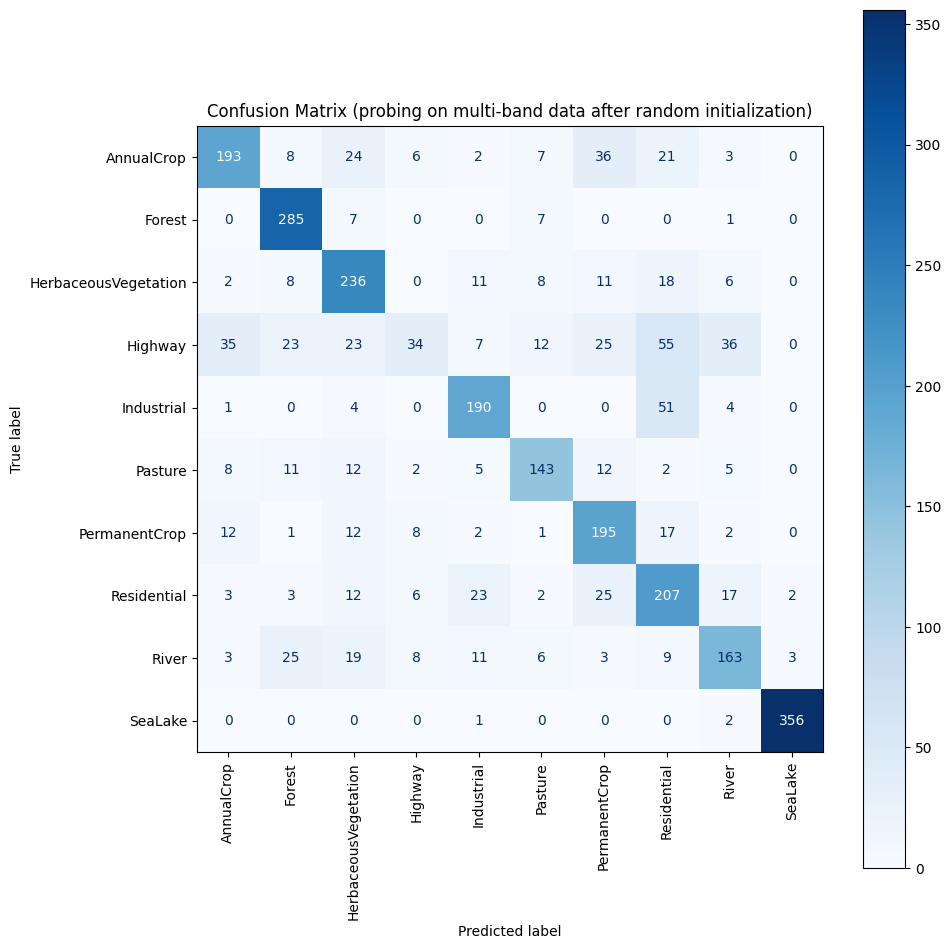

In [24]:
import matplotlib.pyplot as plt
# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix (probing on multi-band data after random initialization)')
plt.tight_layout()
plt.show()